In [2]:
import pandas as pd
import nltk
import re
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [9]:
from matplotlib import pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np
from wordcloud import WordCloud

In [14]:
# Create a clean text function
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)

    tokens = word_tokenize(text)

    return tokens

In [3]:
def stopword_removal(tokens):
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    return tokens

In [4]:
lemmatizer = WordNetLemmatizer()
# Custom lemmatization function using WordNet


def custom_lemma(tokens):
    lemmatized_tokens = []
    pos_mapping = {
        'N': wordnet.NOUN,  # Noun
        'V': wordnet.VERB,  # Verb
        'R': wordnet.ADV,   # Adverb
        'J': wordnet.ADJ    # Adjective
    }
    # Use WordNet to look up lemmas based on part-of-speech (POS) tags
    for token in tokens:
        # Get the POS tag of the token
        pos = nltk.pos_tag([token])[0][1][0].upper()
        if pos in pos_mapping:
            lemmatized_tokens.append(
                lemmatizer.lemmatize(token, pos_mapping[pos]))
        else:
            lemmatized_tokens.append(token)
    return lemmatized_tokens

In [15]:
def preprocessed(text):
    tokens = clean_text(text)
    filtered_tokens = stopword_removal(tokens)
    lemmatized_tokens = custom_lemma(filtered_tokens)
    preprocessed_text = ' '.join(lemmatized_tokens)

    return preprocessed_text

In [8]:
df = pd.read_csv('GA_reviews.csv', index_col=0)

df.head()

,reviews,date
0,✅ Trip Verified | Flew on GA860 Jakarta to Ho...,2024-04-10
1,✅ Trip Verified | Flew on GA-89 Amsterdam to ...,2024-03-20
2,✅ Trip Verified | Flew on GA-88 Jakarta to Am...,2024-03-16
3,✅ Trip Verified | Flew on GA682 Jakarta - Soro...,2024-02-25
4,Not Verified | The ground experience is terrib...,2024-02-25


In [30]:
## Change date into datetime format

df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

In [16]:
df['clean_review'] = df['reviews'].apply(preprocessed)
df.head()

,reviews,date,clean_review
0,✅ Trip Verified | Flew on GA860 Jakarta to Ho...,2024-04-10,trip verify flew ga860 jakarta hong kong met c...
1,✅ Trip Verified | Flew on GA-89 Amsterdam to ...,2024-03-20,trip verify flew ga89 amsterdam jakarta march ...
2,✅ Trip Verified | Flew on GA-88 Jakarta to Am...,2024-03-16,trip verify flew ga88 jakarta amsterdam march ...
3,✅ Trip Verified | Flew on GA682 Jakarta - Soro...,2024-02-25,trip verify flew ga682 jakarta sorong upon ent...
4,Not Verified | The ground experience is terrib...,2024-02-25,verify ground experience terrible garuda inter...


In [19]:
# Remove "trip verify" or "verify" from the beginning of the sentences
df['clean_review'] = df['clean_review'].str.replace(
    r'^trip verify\s*', '', regex=True)
df['clean_review'] = df['clean_review'].str.replace(
    r'^verify\s*', '', regex=True)

## Word Cloud & Frequency

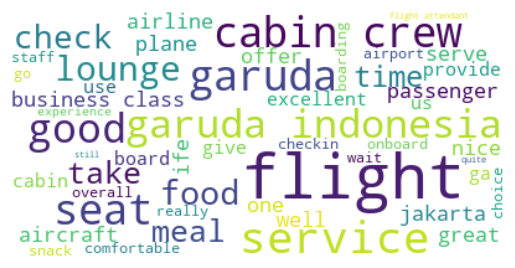

In [18]:
text = ' '.join(df['clean_review'])
# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=50, max_words=50,
                      background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Text(0.5, 1.0, 'Word Frequency')

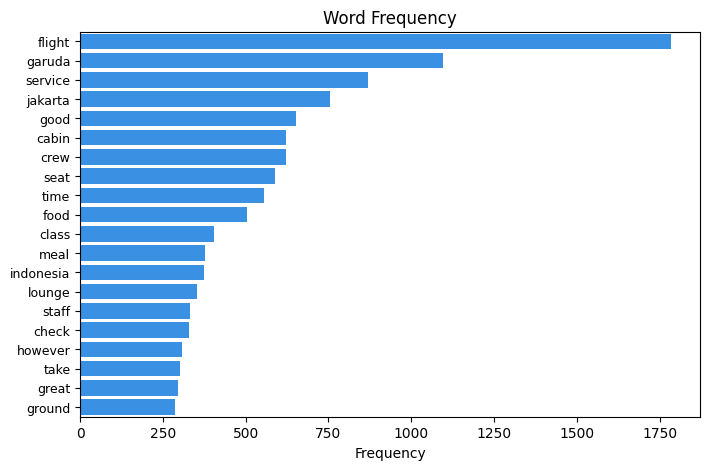

In [20]:
words = text.split()
word_freq = Counter(words)

top_50_words = dict(word_freq.most_common(20))

plt.figure(figsize=(8, 5))
sns.barplot(x=top_50_words.values(), y=top_50_words.keys(), color='dodgerblue')
plt.yticks(fontsize=9)
plt.xlabel('Frequency')
plt.title('Word Frequency')

## Sentiment Analysis

In [33]:
# Vader
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()
sentiments = []
for review in df['clean_review']:
    sentiment_scores = analyzer.polarity_scores(review)

    # Classify sentiment based on compound score
    if sentiment_scores['compound'] >= 0.05:
        sentiment_label = 'Positive'
    elif sentiment_scores['compound'] <= -0.05:
        sentiment_label = 'Negative'
    else:
        sentiment_label = 'Neutral'

    # Store sentiment label
    sentiments.append(sentiment_label)

df['sentiment'] = sentiments

df.head()

,reviews,date,clean_review,sentiment
0,✅ Trip Verified | Flew on GA860 Jakarta to Ho...,2024-04-10,flew ga860 jakarta hong kong met check garuda ...,Positive
1,✅ Trip Verified | Flew on GA-89 Amsterdam to ...,2024-03-20,flew ga89 amsterdam jakarta march 2024 picked ...,Positive
2,✅ Trip Verified | Flew on GA-88 Jakarta to Am...,2024-03-16,flew ga88 jakarta amsterdam march 2024 picked ...,Positive
3,✅ Trip Verified | Flew on GA682 Jakarta - Soro...,2024-02-25,flew ga682 jakarta sorong upon enter checkin a...,Positive
4,Not Verified | The ground experience is terrib...,2024-02-25,ground experience terrible garuda internationa...,Negative


In [4]:
import pandas as pd

df = pd.read_csv('GA_ready_to_use.csv', index_col=0)
df.nunique()

reviews         918
date            751
clean_review    917
sentiment         3
dtype: int64

Text(0.5, 1.0, 'Sentiment Distribution')

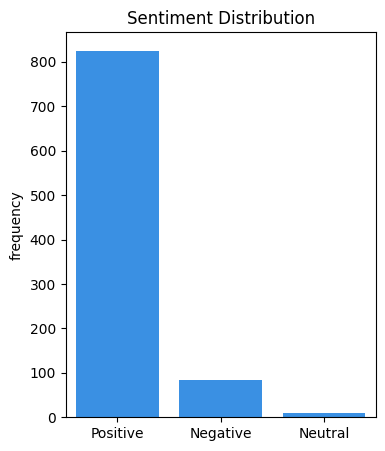

In [10]:
sent_label = df['sentiment'].unique()
sent_freq = df['sentiment'].value_counts()

plt.figure(figsize=(4,5))
sns.barplot(x= sent_label, y=sent_freq, color='dodgerblue')
plt.ylabel('frequency')
plt.title('Sentiment Distribution')

In [17]:
def remove_words_from_string(input_string, words_to_remove):
    # Create a regular expression pattern to match any of the words to remove
    pattern = r'\b(?:' + '|'.join(map(re.escape, words_to_remove)) + r')\b'

    # Use regular expression to replace the words to remove with an empty string
    result_string = re.sub(pattern, '', input_string, flags=re.IGNORECASE)

    # Remove extra spaces
    result_string = re.sub(r'\s+', ' ', result_string).strip()

    return result_string

Text(0.5, 1.0, 'Word Frequency by Negative Sentiment')

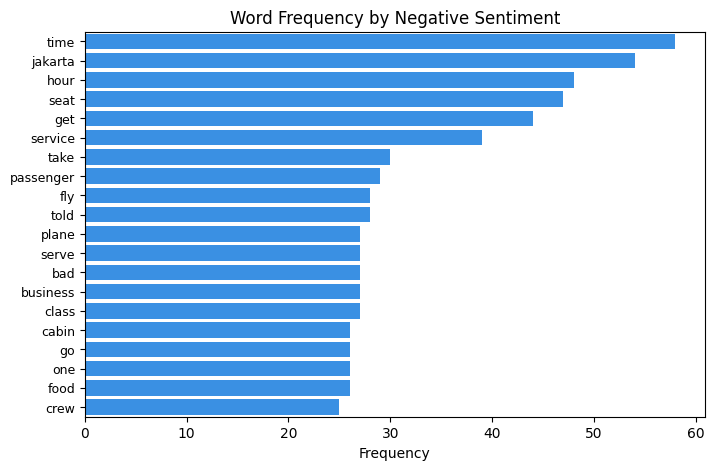

In [19]:
## Analyze word frequency for negative sentiment

df_negative = df[df['sentiment']=='Negative']

text_negative = ' '.join(df_negative['clean_review'])
text_negative = remove_words_from_string(text_negative, ['flight', 'garuda', 'airline'])
token_negative = text_negative.split()

negative_freq = Counter(token_negative)

top_50_words_neg = dict(negative_freq.most_common(20))

plt.figure(figsize=(8, 5))
sns.barplot(x=top_50_words_neg.values(), y=top_50_words_neg.keys(), color='dodgerblue')
plt.yticks(fontsize=9)
plt.xlabel('Frequency')
plt.title('Word Frequency by Negative Sentiment')

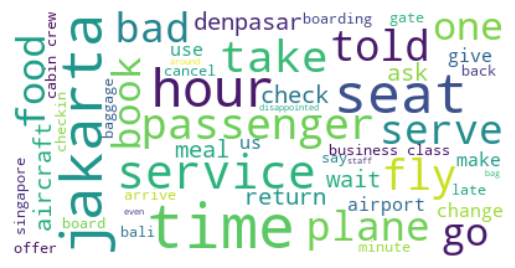

In [38]:
wordcloud_neg = WordCloud(max_font_size=50, max_words=50,
                      background_color="white", colormap='viridis').generate(text_negative)
plt.figure()
plt.imshow(wordcloud_neg, interpolation="bilinear")
plt.axis("off")
plt.show()

Text(0.5, 1.0, 'Word Frequency by Positive Sentiment')

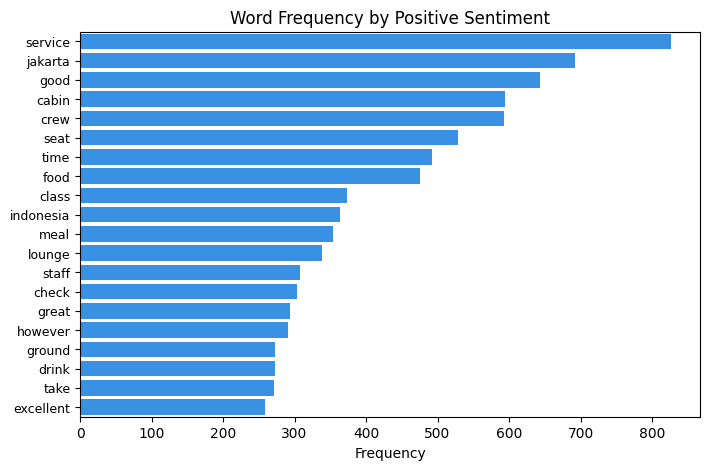

In [20]:
# Analyze word frequency for positive sentiment

df_positive = df[df['sentiment'] == 'Positive']

text_positive = ' '.join(df_positive['clean_review'])
text_positive = remove_words_from_string(text_positive, ['flight','garuda', 'airline'])
token_positive = text_positive.split()

positive_freq = Counter(token_positive)

top_50_words_pos = dict(positive_freq.most_common(20))

plt.figure(figsize=(8, 5))
sns.barplot(x=top_50_words_pos.values(),
            y=top_50_words_pos.keys(), color='dodgerblue')
plt.yticks(fontsize=9)
plt.xlabel('Frequency')
plt.title('Word Frequency by Positive Sentiment')

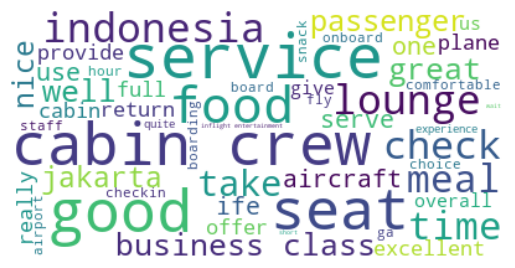

In [37]:
wordcloud_pos = WordCloud(max_font_size=50, max_words=50,
                          background_color="white", colormap='viridis').generate(text_positive)
plt.figure()
plt.imshow(wordcloud_pos, interpolation="bilinear")
plt.axis("off")
plt.show()

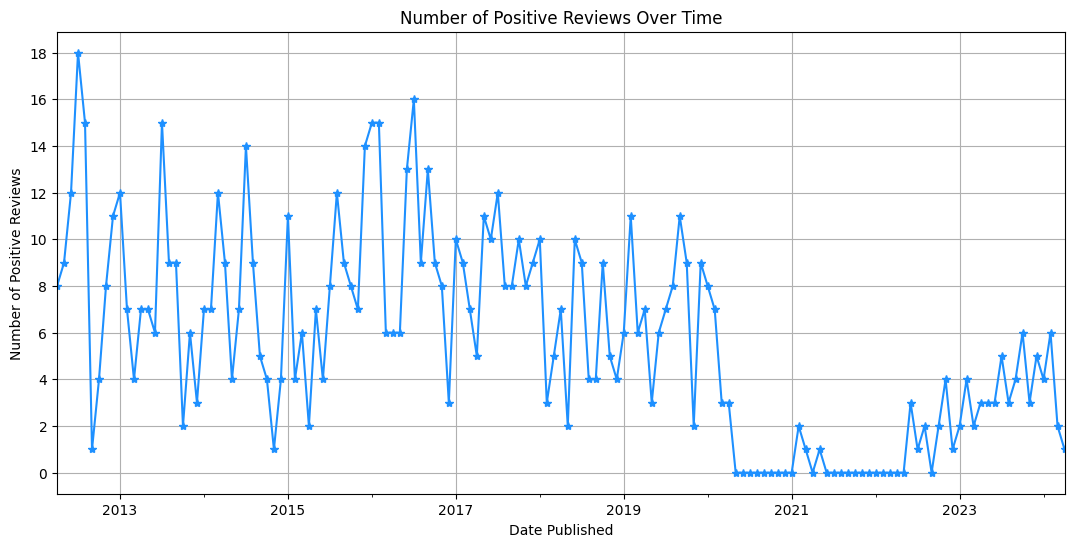

In [74]:
# Group the data by date and count the number of positive reviews for each date
positive_reviews_over_time = df_positive.resample('M', on='date').size()

# Plot the number of positive reviews over time
plt.figure(figsize=(13, 6))
positive_reviews_over_time.plot(linestyle='-', marker='*', color='dodgerblue')
plt.title('Number of Positive Reviews Over Time')
plt.xlabel('Date Published')
plt.ylabel('Number of Positive Reviews')
plt.yticks(np.arange(0, 20, 2))
plt.grid(True)
plt.show()

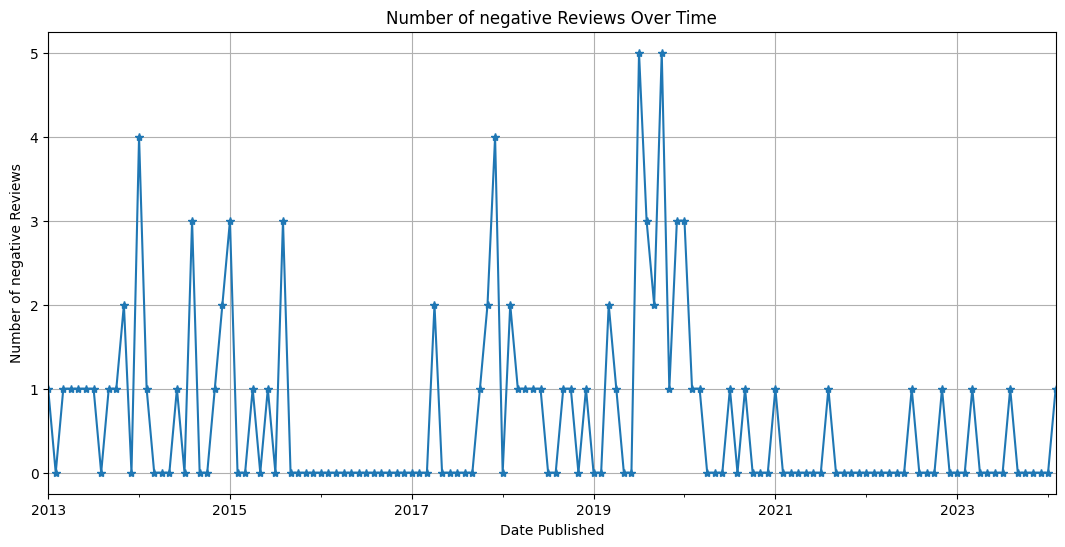

In [73]:
# Group the data by date and count the number of positive reviews for each date
negative_reviews_over_time = df_negative.resample('M', on='date').size()

# Plot the number of negative reviews over time
plt.figure(figsize=(13, 6))
negative_reviews_over_time.plot(linestyle='-', marker='*')
plt.title('Number of negative Reviews Over Time')
plt.xlabel('Date Published')
plt.ylabel('Number of negative Reviews')
plt.yticks(np.arange(0, 6, 1))
plt.grid(True)
plt.show()